## StackingCVClassifier

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
import random

In [2]:
# Read data from stored csv files
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
Final_Dataset_Provider_Train = Final_Dataset_Provider_Train.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')
Final_Dataset_Provider_Test = Final_Dataset_Provider_Test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [3]:
Final_Dataset_Provider_Train.head(2)

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Hospitalization_Duration,Claim_Period,ExtraClaimDays,Inpatient_or_Outpatient,RenalDiseaseIndicator,NoOfMonths_PartACov,...,PerProviderClmDiagnosisCode_4_count_ClaimID,PerProviderClmDiagnosisCode_5_count_ClaimID,PerProviderClmDiagnosisCode_6_count_ClaimID,PerProviderDiagnosisGroupCode_count_ClaimID,Gender_0,Gender_1,Race_1,Race_2,Race_3,Race_5
0,PRV51001,0,104640,5340.0,30.0,61,0.0,5,8,300,...,297,297,297,405,16.0,9.0,21.0,4.0,0.0,0.0
1,PRV51003,1,605670,66286.0,382.0,617,0.0,62,29,1560,...,3046,4452,5556,4972,78.0,54.0,107.0,24.0,0.0,1.0


In [5]:
Final_Dataset_Provider_Train.shape, Final_Dataset_Provider_Test.shape

((5410, 247), (1353, 246))

#### Split your whole data into train and test(80-20)

In [6]:
# Split your whole data into train and test(80-20)
from sklearn.model_selection import train_test_split
Final_Dataset_Provider_Tr, Final_Dataset_Provider_val = train_test_split(Final_Dataset_Provider_Train, test_size=0.2,
                               random_state=42,stratify=Final_Dataset_Provider_Train['PotentialFraud'])
Final_Dataset_Provider_Tr.shape, Final_Dataset_Provider_val.shape

((4328, 247), (1082, 247))

In [7]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Tr.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Tr['PotentialFraud']
x_train.shape, y_train.shape

((4328, 245), (4328,))

In [8]:
# Seperate dependent and independent variables
x_validation_provider_labels = Final_Dataset_Provider_val[['Provider','PotentialFraud']]
x_validation = Final_Dataset_Provider_val.drop(columns=['Provider','PotentialFraud'],axis=1)
y_validation = Final_Dataset_Provider_val['PotentialFraud']
x_validation.shape, y_validation.shape

((1082, 245), (1082,))

In [10]:
# prepare test data
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [11]:
from sklearn.preprocessing import StandardScaler
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_tr = standard_scaler.transform(x_train)
x_val = standard_scaler.transform(x_validation)
x_test_std = standard_scaler.transform(x_test)

# convert pandas.core.series.Series to numpy.ndarray
y_tr = y_train.to_numpy()
y_val = y_validation.to_numpy()

In [12]:
x_val.shape, y_val.shape

((1082, 245), (1082,))

In [13]:
from sklearn.metrics import roc_curve, auc , f1_score
import matplotlib.pyplot as plt
def pred_prob(clf, data):
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [14]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    # plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [15]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

## Build StackingCVClassifier

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.classifier import StackingCVClassifier

### Find best parameters using hyperparameter tuning

In [60]:
# http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/
# Initializing models
RANDOM_SEED = 42
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
clf4 = XGBClassifier()
clf5 = SVC(kernel='linear')
clf6 = LogisticRegression()
clf7 = DecisionTreeClassifier(class_weight = 'balanced')
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6, clf7],
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier__n_neighbors': [5, 10],
          'kneighborsclassifier__leaf_size': [20, 40],
          'randomforestclassifier__n_estimators': [200, 400],
          'randomforestclassifier__max_depth': [5, 10],
          'randomforestclassifier__min_samples_split': [5, 10],
          'gaussiannb__var_smoothing': [1e-5, 1e-9],
          'xgbclassifier__learning_rate': [0.1, 1],
          'xgbclassifier__max_depth': [10, 20],
          'svc__C': [0.1, 1],
          'logisticregression__C': [0.1, 1],
          'decisiontreeclassifier__max_depth': [20,40],
          'decisiontreeclassifier__min_samples_split': [200,250],
          'meta_classifier__C': [0.1, 1]
         }

random_cv = RandomizedSearchCV(estimator=sclf, param_distributions=params, scoring='roc_auc', n_jobs=-1, return_train_score=True, cv=5, refit=True)

random_cv.fit(x_tr, y_tr)

RandomizedSearchCV(cv=5,
                   estimator=StackingCVClassifier(classifiers=[KNeighborsClassifier(n_neighbors=1),
                                                               RandomForestClassifier(random_state=42),
                                                               GaussianNB(),
                                                               XGBClassifier(base_score=None,
                                                                             booster=None,
                                                                             colsample_bylevel=None,
                                                                             colsample_bynode=None,
                                                                             colsample_bytree=None,
                                                                             gamma=None,
                                                                             gpu_id=None,
                             

In [61]:
print("best parameters = ",random_cv.best_params_)
print("roc_auc_score :",random_cv.best_score_)

best parameters =  {'xgbclassifier__max_depth': 20, 'xgbclassifier__learning_rate': 0.1, 'svc__C': 0.1, 'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__max_depth': 10, 'meta_classifier__C': 0.1, 'logisticregression__C': 0.1, 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__leaf_size': 20, 'gaussiannb__var_smoothing': 1e-05, 'decisiontreeclassifier__min_samples_split': 250, 'decisiontreeclassifier__max_depth': 40}
roc_auc_score : 0.8956287662505437


### Use best parameters to train StackingCVClassifier

In [63]:
from sklearn.multiclass import OneVsRestClassifier

# Initializing models
RANDOM_SEED = 42
clf1 = KNeighborsClassifier(n_neighbors=10, leaf_size=20)
clf2 = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=10, random_state=RANDOM_SEED)
clf3 = GaussianNB(var_smoothing=1e-05)
clf4 = XGBClassifier(max_depth=20, learning_rate=0.1)
clf5 = SVC(C=0.1, kernel='linear')
clf6 = SVC(C=0.1, kernel='rbf')
clf7 = SVC(C=0.1, kernel='poly')
clf8 = SVC(C=0.1, kernel='sigmoid')
clf9 = LogisticRegression(C=0.1)
clf10 = DecisionTreeClassifier(min_samples_split=250, max_depth=40, class_weight = 'balanced')
lr = LogisticRegression(C=0.1)

In [66]:
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10], meta_classifier=lr)
classifier = OneVsRestClassifier(sclf)
classifier.fit(x_tr, y_tr)

OneVsRestClassifier(estimator=StackingCVClassifier(classifiers=[KNeighborsClassifier(leaf_size=20,
                                                                                     n_neighbors=10),
                                                                RandomForestClassifier(max_depth=10,
                                                                                       min_samples_split=5,
                                                                                       n_estimators=400,
                                                                                       random_state=42),
                                                                GaussianNB(var_smoothing=1e-05),
                                                                XGBClassifier(base_score=None,
                                                                              booster=None,
                                                                              colsample_bylevel=

Train AUC =  0.983423180168868
Test AUC =  0.899930360008478


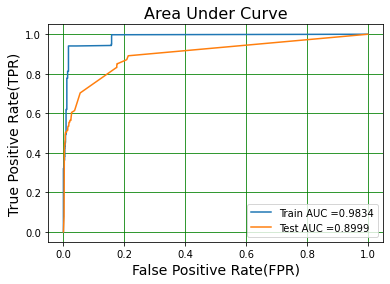

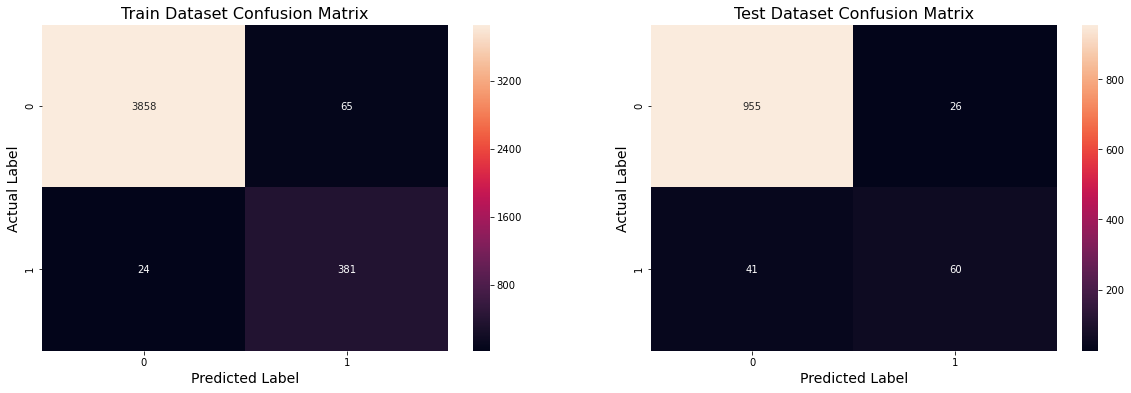

Best Threshold = 0.2595
Model AUC is : 0.8999
Model F1 Score is : 0.6417


In [67]:
test_auc, test_f1_score, best_t = validate_model(classifier, x_tr, x_val, y_tr, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [77]:
y_val_pred = pred_prob(classifier, x_val)
y_val_prediction = predict_with_best_t(y_val_pred, best_t)
x_validation_provider_labels['Predicted_Label'] = y_val_prediction
x_validation_provider_labels = x_validation_provider_labels.reset_index(drop=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
x_validation_provider_labels.head(10)

,Provider,PotentialFraud,Predicted_Label
0,PRV52573,0,0
1,PRV52731,0,0
2,PRV53323,0,0
3,PRV53166,0,0
4,PRV56177,0,0
5,PRV52878,0,0
6,PRV54477,0,0
7,PRV51176,0,0
8,PRV56819,0,0
9,PRV52599,0,0


In [80]:
x_validation_provider_labels.tail(10)

,Provider,PotentialFraud,Predicted_Label
1072,PRV53752,0,0
1073,PRV53539,0,0
1074,PRV52417,0,0
1075,PRV56528,0,0
1076,PRV52340,1,1
1077,PRV53129,0,0
1078,PRV51209,0,0
1079,PRV55446,0,0
1080,PRV56346,0,0
1081,PRV56080,0,0
